In [63]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from datetime import datetime
from docx import Document
from docx.shared import Mm
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.section import WD_SECTION
from docx.enum.section import WD_ORIENT
import math
%run bags_table.ipynb
%run report_functions.ipynb
%run document_helpers.ipynb
%run tree_visualizer.ipynb

In [37]:
# The variable you want to change to the file you have, depending on where this file is
data_file = "/home/dsu/notebooks/islandora_reports/docx_report/data/dsu_repo_data_aug_24_2020.csv"
date = re.search(r"data/dsu_repo_data_(.*).csv", data_file).groups(1)
reports_dir = "/home/dsu/notebooks/islandora_reports/reports/report_prod_24_aug_2020/"
df = pd.read_csv(data_file, error_bad_lines=False, engine="python")

Skipping line 97450: unexpected end of data


In [39]:
collectionCSVNamesToName = {"info:fedora/photoservices:root":"UTSC Photoservices",
"info:fedora/tamil:beckvideos":"Brenda Beck Media",
"info:fedora/utschidden:archives":"Hidden UTSC Archives",
"info:fedora/ottomanempire:collection":"Ottoman Empire Collection",
"info:fedora/hogarth:test201711":"Hogarth Test Collection",
"info:fedora/dsu:library":"DSU Library Collection",
"info:fedora/linc:65e81fe3-bb72-4079-819e-2da0b6b96778":"LINC collection",
"info:fedora/hogarth:harlots":"Hogarth Harlots Progress",
"info:fedora/nearbystudies:collection":"Scarborough Oral Histories Collection",
"info:fedora/hogarth:fourtimesday":"Hogarth Times of Day",
"info:fedora/tamil:beck":"Brenda Beck Collections",
"info:fedora/harleyspiller:newyorkqueenscountybqa":"QA Harley Spiller",
"info:fedora/doris:collection":"Doris McCarthy Collection",
"info:fedora/hogarth:stages":"Hogarth Stages",
"info:fedora/hogarth:marriage":"Hogarth Marriage",
"info:fedora/hogarth:hpic":"Hogarth Root Collection",
"info:fedora/islandora:root":"Islandora Root Collection",
"info:fedora/animalempire:root":"Animal Empire Collection",
"info:fedora/dsu:scarborough-data":"Scarborough Data Collection",
"info:fedora/dsu:workshops":"Library Workshop Collection",
"info:fedora/hogarth:rakesprogress":"Hogarth Rake's Progress",
"info:fedora/hogarth:root":"Hogarth Root Collection",
"info:fedora/harleyspiller:collection":"Harley Spiller Collection",
"info:fedora/harleyspiller:englandqa":"Harley Spiller QA Collection",
"info:fedora/nearbystudies:931":"Nearby Studies Collection",
"info:fedora/dsu:root":"Digital Scholarship Unit Root Collection",
"info:fedora/photoservices:kenjones":"Ken Jones Collection",
"info:fedora/harleyspiller:testing":"Harley Spiller Testing Collection",
"info:fedora/gundagunde:public":"Gunda Gunde Collection",
"info:fedora/utsc:archives":"UTSC Legacy Archives Collection",
"info:fedora/gundagunde:all":"Gunda Gunde Collection",
"info:fedora/harleyspiller:unitedstatesnewyorkeeriecountyqa":"Harley Spiller QA Collection",
"info:fedora/dsu:menus":"Menus Collections",
"info:fedora/harleyspiller:QA":"Harley Spiller QA Collection",
"info:fedora/tamil:digital-tamil-studies-project":"Digital Tamil Studies Collection",
"info:fedora/tamil:collection":"Tamil Collections",
"info:fedora/hogarth:industryidleness":"Hogarth Industry and Idleness"}
collRegex = r"^info:fedora/(.*):(.*)$"
# Content Model
modelCSVNamesToNames = {"info:fedora/islandora:sp_large_image_cmodel": "Large Images",
"info:fedora/islandora:bookCModel":"Paged Content",
"info:fedora/islandora:collectionCModel":"Collections",
"info:fedora/islandora:oralhistoriesCModel":"Transcribed Media",
"info:fedora/islandora:sp_videoCModel":"Videos",
"info:fedora/islandora:sp_basic_image":"Basic Images",
"info:fedora/islandora:sp_pdf":"PDFs",
"info:fedora/islandora:binaryObjectCModel":"Binary Files",
"info:fedora/islandora:sp-audioCModel":"Audio Files"}
#Date
regex = r"^.*day, (.*) [0-9]*, (.*) - [0-2][0-9]:[0-5][0-9]$"


In [40]:
# orphanPIDs = []
# for index, row in df.iterrows():
#     isConceptual = pd.isna(row["isPageOf"]) and pd.isna(row["isConstituentOf"])
#     # Check if the PID is an orphan
#     if not isConceptual:
#         if pd.notna(row["isPageOf"]):
#             parentPID = row["isPageOf"]
#         elif pd.notna(row["isConstituentOf"]):
#             parentPID = row["isConstituentOf"]
#         parentPID = parentPID.split("info:fedora/")[1]
#         if not DoesPIDExist(df, parentPID):
#             #print(row["PID"], parentPID)
#             orphanPIDs.append(row["PID"])

In [65]:
# Constructs the tree and adds missing collections
errorMsg = " - Error in file format"
tree = ConstructTreeDict(df, collectionCSVNamesToName)
collectionsConceptDict = {}
for name in collectionCSVNamesToName.values():
    collectionsConceptDict[name] = 0


totalConceptObjects = 0
# Dictionary to store file types
collectionsToFileTypesDict = {}
for name in collectionCSVNamesToName.values():
    collectionsToFileTypesDict[name] = set()

cmodelsDict = {}
for name in modelCSVNamesToNames.values():
    cmodelsDict[name] = 0
#Checksum
numChecksum = 0
#Date
dateDict = {}
#Populate the dictionaries for collection members, conceptual objects
for index, row in df.iterrows():
    #Content Model
    model = row["cmodel"]
    if pd.notna(model):            
            if model in modelCSVNamesToNames:
                modelName = modelCSVNamesToNames[model]
            else:
                modelName = ConvertCSVNameToName(model, collRegex, modelCSVNamesToNames)
                cmodelsDict[modelName] = 0
            cmodelsDict[modelName] += 1
    # Members of Collections
    collection = row["isMemberOfCollection"]
    isConceptual = pd.isna(row["isPageOf"]) and pd.isna(row["isConstituentOf"])
    #Collection sorting
    if pd.notna(collection):
        if collection not in collectionCSVNamesToName:
            print(collection)
            collName = ConvertCSVNameToName(collection, collRegex, collectionCSVNamesToName)
            collectionsConceptDict[collName] = 0
        else:
            collName = collectionCSVNamesToName[collection]
        if isConceptual:
            collectionsConceptDict[collName]+=1
            totalConceptObjects += 1        
    #Dates
    date_full = row["fgs_lastModifiedDate_dt"]
    if pd.notna(date_full) and isConceptual:
        group = re.search(regex, date_full).group
        date = group(1)+" "+group(2)
        if date not in dateDict:
            dateDict[date] = 1
        else:
            dateDict[date] += 1
print(cmodelsDict)
print(collectionCSVNamesToName)
print(collectionsConceptDict)
print(dateDict)
#print(len(orphanPIDs))

{'Large Images': 3616, 'Paged Content': 10725, 'Collections': 32, 'Transcribed Media': 304, 'Videos': 5, 'Basic Images': 25122, 'PDFs': 1006, 'Binary Files': 57, 'Audio Files': 1, 'Islandora pageCModel': 56485, 'Islandora compoundCModel': 95}
{'info:fedora/photoservices:root': 'UTSC Photoservices', 'info:fedora/tamil:beckvideos': 'Brenda Beck Media', 'info:fedora/utschidden:archives': 'Hidden UTSC Archives', 'info:fedora/ottomanempire:collection': 'Ottoman Empire Collection', 'info:fedora/hogarth:test201711': 'Hogarth Test Collection', 'info:fedora/dsu:library': 'DSU Library Collection', 'info:fedora/linc:65e81fe3-bb72-4079-819e-2da0b6b96778': 'LINC collection', 'info:fedora/hogarth:harlots': 'Hogarth Harlots Progress', 'info:fedora/nearbystudies:collection': 'Scarborough Oral Histories Collection', 'info:fedora/hogarth:fourtimesday': 'Hogarth Times of Day', 'info:fedora/tamil:beck': 'Brenda Beck Collections', 'info:fedora/harleyspiller:newyorkqueenscountybqa': 'QA Harley Spiller', 'in

In [66]:
# This section deals with creating the table with the size of each collection, as well as creating a table
# with data types for each collections, and also adding checksum, OBJ details and total number of objects (table 2 in report)
collectionsDict = {}
totalCollections = 0
totalSizeDict = {}
totalOBJCollections = 0
totalSize = 0
collectionsOBJDict = {}
collectionsToChecksumDict = {}
collectionsToFileTypesDict = {}
# Creates a new dataframe for each of the collections and expands it, and then loops through each of those
# dataframes and finds out the file types, the size, the number of objects, the number of objects with checksum
# and the number of objects with OBJ
for key, collName in collectionCSVNamesToName.items():
    collDf = pd.DataFrame()
    print(key)
    collDf = GetMembers(df, collDf, key, True)
    if collName not in collectionsDict:
        collectionsDict[collName]  = 0
        totalSizeDict[collName] = 0
        collectionsOBJDict[collName] = 0
        collectionsToChecksumDict[collName] = 0
        collectionsToFileTypesDict[collName] = set()
    # Populate the total number of objects dictionary
    collectionsDict[collName]  += collDf.shape[0]
    print(collName, collectionsDict[collName], collDf.shape[0])
    totalCollections += collectionsDict[collName]
    if collDf.shape[0] != 0:
        size = GetSizeForCollection(collDf)
    else:
        size = 0
    print(size)
    totalSizeDict[collName] += size
    totalSize+=size
    # The section that deals with file types and checksums
    for index,row in collDf.iterrows():
        # Check if the PID is an orphan
        # Collection sorting
        model = row["cmodel"]
        # Increments the number of objects with OBJ. 
        if model != "info:fedora/islandora:bookCModel" and  model != "info:fedora/islandora:compoundCModel":
                collectionsOBJDict[collName]+=1
                totalOBJCollections+=1
        if(pd.notna(row["obj_format"])):
                if collName not in collectionsToFileTypesDict:
                    collectionsToFileTypesDict[collName] = set()
                # Remove errors
                if ", ERROR:" in row["obj_format"]:
                    filetype = row["obj_format"].split(", ERROR:")[0]+errorMsg
                else:
                    filetype = row["obj_format"].split(", ")[0]
                collectionsToFileTypesDict[collName].add(filetype)    
        checksum = row["obj_checksum"]
        # Increments the number of objects with checksum.
        if checksum != "not_set":
                numChecksum+=1
                if collName not in collectionsToChecksumDict:
                    collectionsToChecksumDict[collName] = 0
                collectionsToChecksumDict[collName]+=1
# Convert to the actual size units
for key, value in totalSizeDict.items():
    totalSizeDict[key] = convert_size(value)
totalSize = convert_size(totalSize)
print(totalSize)

info:fedora/photoservices:root
UTSC Photoservices 452 452
51875050303
info:fedora/tamil:beckvideos
Brenda Beck Media 112 112
43761475798
info:fedora/utschidden:archives
Hidden UTSC Archives 27 27
964509942
info:fedora/ottomanempire:collection
Ottoman Empire Collection 0 0
0
info:fedora/hogarth:test201711
Hogarth Test Collection 7 7
52282880
info:fedora/dsu:library
DSU Library Collection 7 7
418470612
info:fedora/linc:65e81fe3-bb72-4079-819e-2da0b6b96778
LINC collection 0 0
0
info:fedora/hogarth:harlots
Hogarth Harlots Progress 0 0
0
info:fedora/nearbystudies:collection
Scarborough Oral Histories Collection 183 183
54669950661
info:fedora/hogarth:fourtimesday
Hogarth Times of Day 4 4
323547593
info:fedora/tamil:beck
Brenda Beck Collections 6030 6030
29916163515
info:fedora/harleyspiller:newyorkqueenscountybqa
QA Harley Spiller 224 224
4086316
info:fedora/doris:collection
Doris McCarthy Collection 1623 1623
53968760898
info:fedora/hogarth:stages
Hogarth Stages 0 0
0
info:fedora/hogarth:m

new
not found gundagunde:43226
not found gundagunde:48185
not found gundagunde:56372
not found gundagunde:20364
not found gundagunde:55833
not found gundagunde:47118
not found gundagunde:114778
not found gundagunde:47894
not found gundagunde:115713
not found gundagunde:53389
not found gundagunde:41547


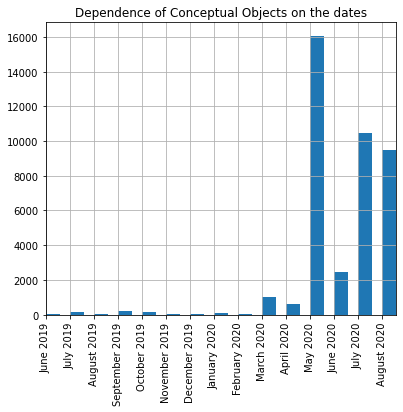

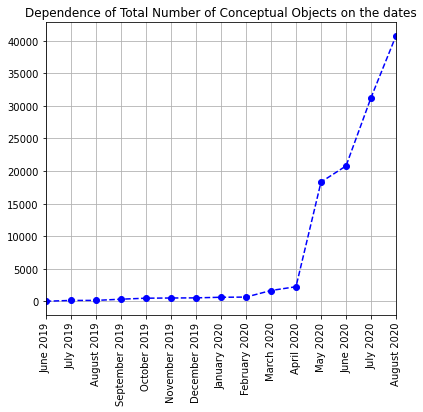

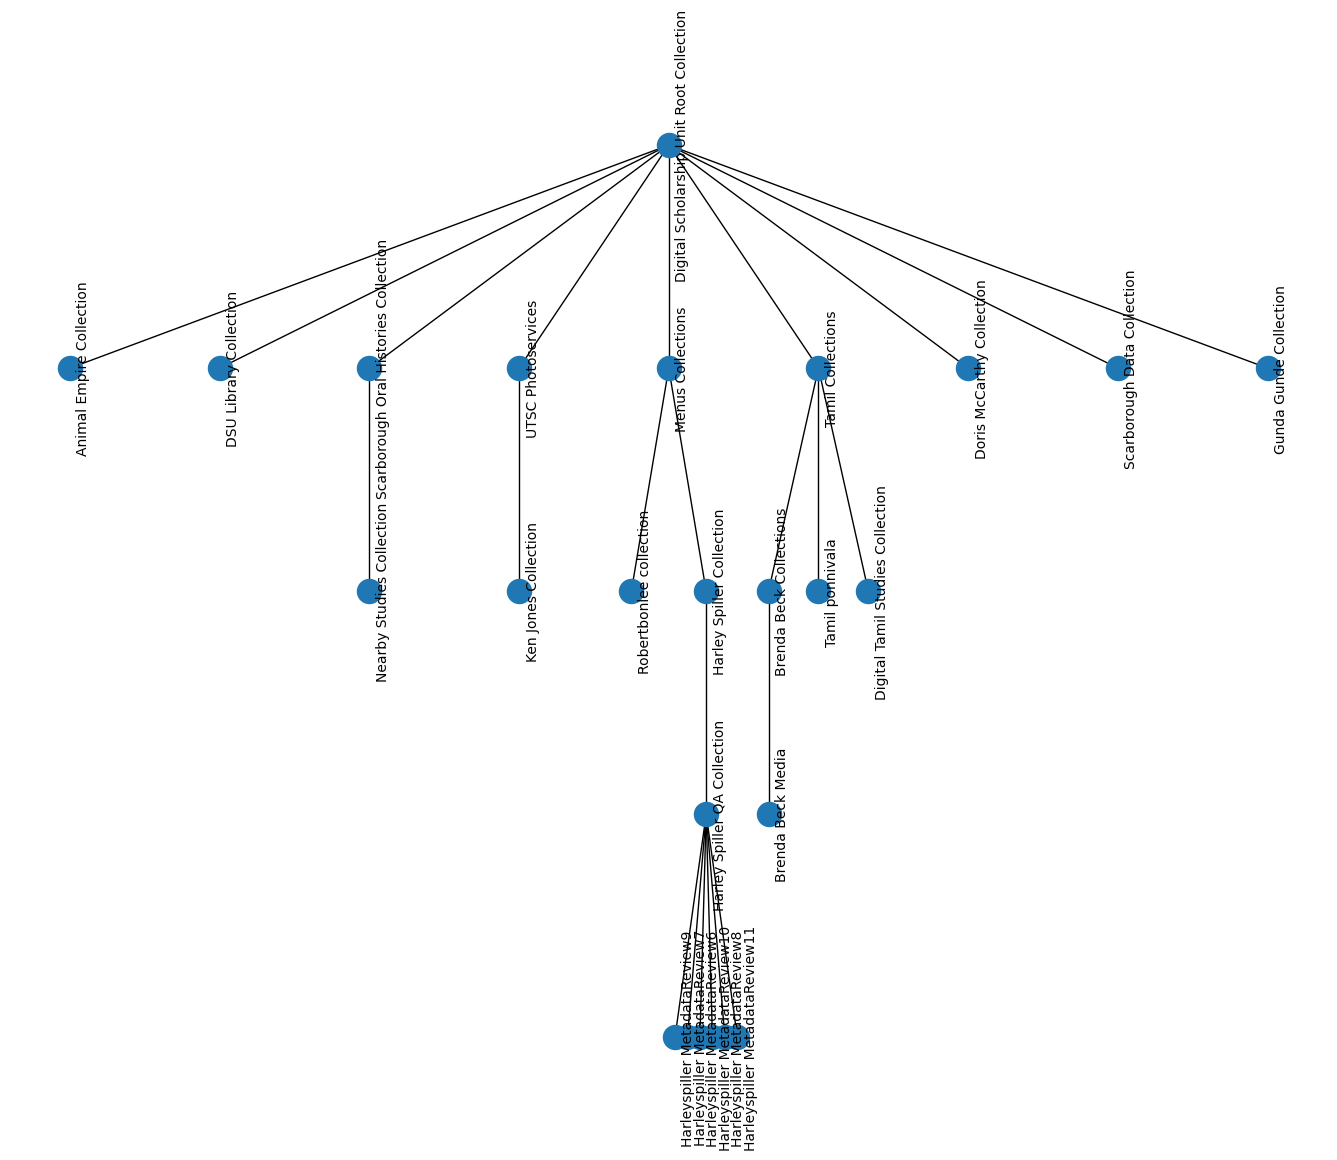

In [64]:
document = Document()
style = document.styles['Header']
font = style.font
font.size = Pt(15)
# Generate date plot
sort = sorted(dateDict.items(), key=lambda x: datetime.strptime(x[0], "%B %Y"))
GenerateTitle(document,"Relation between the objects and the date","Graph 1",
              "This graph shows the number of digital objects entering the repository over time")

GenerateBarPlot(list(zip(*sort))[0],list(zip(*sort))[1], "datePlot.png", "Dependence of Conceptual Objects on the dates")
document.add_picture('datePlot.png', width = Mm(150))
document.add_page_break()

# Generate total objects
GenerateTitle(document, "Relation between the objects and the date","Graph 2",
              "This graph shows the number of digital objects entering the repository over time")
totalValues = []
total = 0
for tpl in sort:
    total+=tpl[1]
    totalValues.append(total)
GenerateLinePlot(list(zip(*sort))[0],totalValues,"cumulativePlot.png","Dependence of Total Number of Conceptual Objects on the dates")
document.add_picture("cumulativePlot.png", width = Mm(150))

# Generate content model chart
document.add_page_break()
GenerateTitle(document, "Number of objects for each content model","Table 1",
              "This chart shows the number of objects per Islandora content model in the repository")
table = document.add_table(rows=len(cmodelsDict)+2, cols=2)
GenerateTable("Content Models", "Digital Objects", cmodelsDict, table)
row = table.rows[-1]
row.cells[0].paragraphs[0].add_run("Total").bold = True
row.cells[1].paragraphs[0].add_run(str(sum(cmodelsDict.values()))).bold = True
document.add_page_break()

# Generate collection chart (table 2)
GenerateTitle(document, "Number of objects and checksums for each collection","Table 2",
              "This chart shows the checksums per collection, and indicates if all are valid")
table = document.add_table(rows=len(collectionsDict)+2, cols=5)
table.style = 'Table Grid'
i = 1

row = table.rows[0]
row.cells[0].paragraphs[0].add_run("Members of Collection").bold = True
row.cells[1].paragraphs[0].add_run("Number of Objects").bold = True
row.cells[2].paragraphs[0].add_run("Conceptual Objects").bold = True
row.cells[3].paragraphs[0].add_run("Objects with OBJ").bold = True
row.cells[4].paragraphs[0].add_run("Objects with checksum").bold = True
for key, value in sorted(collectionsOBJDict.items()):
    row = table.rows[i]
    row.cells[0].text = key
    row.cells[1].text = str(collectionsDict[key])
    row.cells[2].text = str(collectionsConceptDict[key])
    row.cells[3].text = str(value)
    row.cells[4].text = str(collectionsToChecksumDict[key])
    i+=1
row = table.rows[-1]
row.cells[0].paragraphs[0].add_run("Total").bold = True
row.cells[1].paragraphs[0].add_run(str(totalCollections)).bold = True
row.cells[2].paragraphs[0].add_run(str(totalConceptObjects)).bold = True
row.cells[3].paragraphs[0].add_run(str(totalOBJCollections)).bold = True
row.cells[4].paragraphs[0].add_run(str(numChecksum)).bold = True
document.add_page_break()

#AIP Table
GenerateTitle(document, "Number of objects with AIPs for each collection","Table 3",
              "This chart shows the AIPs per collection, and indicates if all are valid")
table = document.add_table(rows=len(collectionsDict)+2, cols=4)
table.style = 'Table Grid'
i = 1

row = table.rows[0]
row.cells[0].paragraphs[0].add_run("Members of Collection").bold = True
row.cells[1].paragraphs[0].add_run("Conceptual Objects").bold = True
row.cells[2].paragraphs[0].add_run("Number of AIPs").bold = True
row.cells[3].paragraphs[0].add_run("Number of Valid AIPs").bold = True
(collectionAIP, totalAIP, totalValidAIP) = GetValidAIPForCollection(df, collectionCSVNamesToName)
for key, value in sorted(collectionsOBJDict.items()):
    row = table.rows[i]
    row.cells[0].text = key
    row.cells[1].text = str(collectionsConceptDict[key])
    if key not in collectionAIP:
        row.cells[2].text = "0"
        row.cells[3].text = "0"
    else:
        row.cells[2].text = str(collectionAIP[key][0])
        row.cells[3].text = str(collectionAIP[key][1])
    i+=1
row = table.rows[-1]
row.cells[0].paragraphs[0].add_run("Total").bold = True
row.cells[1].paragraphs[0].add_run(str(totalConceptObjects)).bold = True
row.cells[2].paragraphs[0].add_run(str(totalAIP)).bold = True
row.cells[3].paragraphs[0].add_run(str(totalValidAIP)).bold = True
document.add_page_break()
# Generate collection by size chart
GenerateTitle(document,"Total Size of each collection","Table 4")
table = document.add_table(rows=len(totalSizeDict)+2, cols=2)
GenerateTable("Members of Collections", "Approximate Total Size",totalSizeDict, table)
row = table.rows[-1]
row.cells[0].paragraphs[0].add_run("Total").bold = True
row.cells[1].paragraphs[0].add_run(str(totalSize)).bold = True
document.add_page_break()
# Generate collection by file type chart
leavesOnly = GetNodesWithNoChildren(tree)
leavesCollectionsToFileTypesDict = {key: collectionsToFileTypesDict[key] for key in leavesOnly}
GenerateTitle(document,"File Types for each collection","Table 5")
table = document.add_table(rows=len(leavesCollectionsToFileTypesDict)+1, cols=2)
table.style = 'Table Grid'
i = 1
row = table.rows[0]
row.cells[0].paragraphs[0].add_run("Members of Collections").bold = True
row.cells[1].paragraphs[0].add_run("File types").bold = True
for key, value in sorted(leavesCollectionsToFileTypesDict.items()):
    row = table.rows[i]
    row.cells[0].text = key
    if value != set():
        row.cells[1].text = "-"
    row.cells[1].text += "\n-".join(value)
    i+=1
# Tree structure
document.add_page_break()
current_section = document.sections[-1]
new_width, new_height = current_section.page_height, current_section.page_width
GenerateTitle(document,"Collection Tree","Graph 3",)
CreateTree(tree)
document.add_picture('treeTestTranspose.png', width = Mm(150))
document.save('ReportSummary.docx')

In [49]:
newDf = pd.DataFrame(orphanPIDs, columns=["Orphan PIDs"])
newDf.to_csv('orphanPIDs.csv')

In [33]:
collectionsToFileTypes.keys()

NameError: name 'collectionsToFileTypes' is not defined